<a href="https://colab.research.google.com/github/ematala/satellite-segmentation/blob/main/SatelliteSegmentation.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Initialization

## Imports

In [ ]:
import os, datetime, math
import numpy as np
import tensorflow as tf
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, classification_report, accuracy_score, f1_score
from sklearn.model_selection import train_test_split, GridSearchCV, RandomizedSearchCV
from seaborn import heatmap
from sklearn.utils import class_weight
from matplotlib import cm
from matplotlib.patches import Patch
import matplotlib.patches as mpatches

from scipy.stats import randint

In [ ]:
!pip install catboost
from catboost import CatBoostClassifier

In [ ]:
 # only run on colab
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
%matplotlib inline

## Global parameters

In [ ]:
# paths
PATH = '/content/drive/MyDrive/Colab Notebooks/satellite-segmentation/data/'

# use gpu if possible
TASK = 'GPU' if tf.config.list_physical_devices('GPU') else 'CPU'

# set the pixel to extract
PIXEL_X = 16
PIXEL_Y = 16

# layers and step size
NUM_LAYERS = 0
STEP_SIZE = 1

TRAIN_SPLIT = 0.25

# run mode
WITH_GRIDSEARCH = False

# random seed
SEED = 42

# catBoost params
BEST_PARAMS = {
    "learning_rate": 0.05,
    "depth": 7,
    "l2_leaf_reg":3
               }
# training iterations
ITERS = 2000


## Load data

In [ ]:
raw_data = np.load(f'{PATH}train.npz')

data = raw_data['bands']
labels = raw_data['lulc']

test = np.load(f'{PATH}hidden_test.npz')['bands']

classes = np.array(['No Data', 'Cultivated Land', 'Forest', 'Grassland', 'Shrubland', 'Water', 'Wetlands', 'Tundra', 'Artificial Surface', 'Bareland', 'Snow and Ice'])

## Preprocessing

In [ ]:
# Input: (n,12,33,33,6)
# Output: (n, 72*(1+max_padding))

def surrounding_pixel_means(data, num_layers, step_size):
  pixel_sets = []

  num_data_points = data.shape[0]

  # extract only center points:
  train_data_center_points = data[:,:,PIXEL_X,PIXEL_Y,:]
  train_data_center_points_reshaped = train_data_center_points.reshape(num_data_points,12*6)

  if num_layers > 0:

    # loop over 
    for i in range(1,num_layers+1, step_size):
      pixel_sets.append(data[:,:,PIXEL_X-i:PIXEL_X+i,PIXEL_Y-i:PIXEL_Y+i,:])

    # compute means for each of the sets per month and per channel:
    pixel_sets_mean = [np.mean(pixel_set, axis=(2,3)) for pixel_set in pixel_sets]

    # flatten month and channel data by reshaping:
    pixel_sets_mean_reshaped = [np.reshape(pixel_set,(num_data_points,12*6)) for pixel_set in pixel_sets_mean]

    # combine sets:
    sets_combined = np.concatenate(pixel_sets_mean_reshaped, axis=1)

    # combine sets with central pixels:
    return np.concatenate((sets_combined, train_data_center_points_reshaped), axis=1)
  
  else:
    return train_data_center_points_reshaped

In [ ]:
def preprocess(x, y, labels=None):
  x = x[y != 0, :, :, :, :] if labels == 'exclude_no_data' else x[y == 0, :, :, :, :] if labels == 'only_no_data' else x
  y = y[y != 0] if labels == 'exclude_no_data' else y[y == 0] if labels == 'only_no_data' else y

  x = surrounding_pixel_means(x, NUM_LAYERS, STEP_SIZE)

  x_train, x_val, y_train, y_val = train_test_split(x, y, test_size=TRAIN_SPLIT, random_state=SEED, stratify = y)

  return x_train, x_val, y_train, y_val

# Modelling

## Training with only labelled data

In [ ]:
# use only labelled data for training
x_train, x_val, y_train, y_val = preprocess(data, labels, 'exclude_no_data')
f'train: {x_train.shape} {y_train.shape}, validation: {x_val.shape} {y_val.shape}'

'train: (6519, 72) (6519,), validation: (2173, 72) (2173,)'

In [ ]:
cbm = CatBoostClassifier(learning_rate=0.1, iterations=ITERS, random_seed=SEED, logging_level='Silent', task_type=TASK)

# set global params:
cbm.set_params(**BEST_PARAMS)

# fit on labelled data
cbm.fit(x_train, y_train)

In [ ]:
# evaluate the model
cbm_train = cbm.predict(x_train).reshape(-1)
cbm_val = cbm.predict(x_val).reshape(-1)

print('Training\n')
print(f'Accuracy: {accuracy_score(y_train, cbm_train)*100}')
print(f'F1-Score: {f1_score(y_train, cbm_train, average=None)*100}')
print(classification_report(y_train, cbm_train))

print('\n')

print('Validation\n')
print(f'Accuracy: {accuracy_score(y_val, cbm_val)*100}')
print(f'F1-Score: {f1_score(y_val, cbm_val, average=None)*100}')
print(classification_report(y_val, cbm_val))

Training

Accuracy: 99.96932044792146
F1-Score: [100.          99.97700092  99.94072318  99.91341991 100.
 100.         100.        ]
              precision    recall  f1-score   support

           1       1.00      1.00      1.00       178
           2       1.00      1.00      1.00      4347
           3       1.00      1.00      1.00       844
           4       1.00      1.00      1.00       578
           5       1.00      1.00      1.00        43
           8       1.00      1.00      1.00       163
           9       1.00      1.00      1.00       366

    accuracy                           1.00      6519
   macro avg       1.00      1.00      1.00      6519
weighted avg       1.00      1.00      1.00      6519



Validation

Accuracy: 84.30740911182697
F1-Score: [68.42105263 92.97900262 69.4980695  44.51612903 69.56521739 62.22222222
 74.89711934]
              precision    recall  f1-score   support

           1       0.72      0.65      0.68        60
           2       0.

In [ ]:
# fit the model on full labelled data, i. e. combine the splits
cbm.fit(np.concatenate((x_train, x_val)), np.concatenate((y_train, y_val)))

## Semi-supervised learning

### Predict labels for unlabelled data

In [ ]:
# predict labels for unlabelled data
unlabelled_data = surrounding_pixel_means(data[labels == 0], NUM_LAYERS, STEP_SIZE)

predicted_labels = cbm.predict(unlabelled_data).reshape(-1)

In [ ]:
# train the model on labelled training instances and add predicted labels
x_train = np.concatenate((x_train, unlabelled_data))
y_train = np.concatenate((y_train, predicted_labels))
cbm.fit(x_train, y_train)

In [ ]:
# evaluate the model
cbm_train = cbm.predict(x_train).reshape(-1)
cbm_val = cbm.predict(x_val).reshape(-1)

print('Training\n')
print(f'Accuracy: {accuracy_score(y_train, cbm_train)*100}')
print(f'F1-Score: {f1_score(y_train, cbm_train, average=None)*100}')
print(classification_report(y_train, cbm_train))

print('\n')

print('Validation\n')
print(f'Accuracy: {accuracy_score(y_val, cbm_val)*100}')
print(f'F1-Score: {f1_score(y_val, cbm_val, average=None)*100}')
print(classification_report(y_val, cbm_val))

Training

Accuracy: 99.89778970231251
F1-Score: [100.          99.94409243  99.7979798   99.50576606 100.
 100.         100.        ]
              precision    recall  f1-score   support

           1       1.00      1.00      1.00       184
           2       1.00      1.00      1.00      5363
           3       1.00      1.00      1.00       990
           4       1.00      0.99      1.00       610
           5       1.00      1.00      1.00        44
           8       1.00      1.00      1.00       205
           9       1.00      1.00      1.00       431

    accuracy                           1.00      7827
   macro avg       1.00      1.00      1.00      7827
weighted avg       1.00      1.00      1.00      7827



Validation

Accuracy: 83.70915784629544
F1-Score: [62.96296296 92.86182056 68.67924528 41.96721311 69.56521739 55.81395349
 74.16666667]
              precision    recall  f1-score   support

           1       0.71      0.57      0.63        60
           2       0.

### Full fit with only labelled data

In [ ]:
# final step: fit the model on all labelled data
labelled_data = surrounding_pixel_means(data[labels != 0], NUM_LAYERS, STEP_SIZE)

labelled_data_labels = labels[labels != 0]
cbm.fit(labelled_data, labelled_data_labels)

### Full prediction of labels

In [ ]:
# predict labels for unlabelled data
predicted_labels = cbm.predict(unlabelled_data).reshape(-1)

# overwrite existing labels without label
new_labels = labels.copy()
new_labels[labels == 0] = predicted_labels

## Hyperparameter Tuning

In [ ]:
# create full dataset with all training instances and labels (including predicted labels)
full_data = surrounding_pixel_means(data, NUM_LAYERS, STEP_SIZE)

In [ ]:
# Get default params:
print(cbm.get_all_params())

{'nan_mode': 'Min', 'gpu_ram_part': 0.95, 'eval_metric': 'MultiClass', 'iterations': 2000, 'leaf_estimation_method': 'Newton', 'observations_to_bootstrap': 'TestOnly', 'grow_policy': 'SymmetricTree', 'boosting_type': 'Plain', 'feature_border_type': 'GreedyLogSum', 'bayesian_matrix_reg': 0.10000000149011612, 'devices': '-1', 'pinned_memory_bytes': '104857600', 'l2_leaf_reg': 3, 'random_strength': 1, 'rsm': 1, 'boost_from_average': False, 'gpu_cat_features_storage': 'GpuRam', 'fold_size_loss_normalization': False, 'model_size_reg': 0.5, 'pool_metainfo_options': {'tags': {}}, 'use_best_model': False, 'meta_l2_frequency': 0, 'class_names': [1, 2, 3, 4, 5, 8, 9], 'random_seed': 42, 'depth': 7, 'border_count': 128, 'min_fold_size': 100, 'data_partition': 'DocParallel', 'bagging_temperature': 1, 'classes_count': 0, 'auto_class_weights': 'None', 'leaf_estimation_backtracking': 'AnyImprovement', 'best_model_min_trees': 1, 'min_data_in_leaf': 1, 'add_ridge_penalty_to_loss_function': False, 'loss

In [ ]:
# Creating the hyperparameter grid
# Based on Docs: https://catboost.ai/docs/concepts/python-reference_catboost_randomized_search.html

param_dist = {"learning_rate": [0.05, 0.08, 0.1, 0.12],
              "depth": randint(3, 10),
              "l2_leaf_reg":[1, 2, 3, 5, 7]}

In [ ]:
#Instantiate RandomSearchCV object
rscv = RandomizedSearchCV(cbm , param_dist, scoring='accuracy', cv=4, n_iter=25, verbose=10, n_jobs=-1)

In [ ]:
#Fit the model#
if WITH_GRIDSEARCH:
  rscv.fit(full_data, new_labels)

In [ ]:
if WITH_GRIDSEARCH:
  # Best model:
  best_model = rscv.best_estimator_

  # Best accuracy:
  best_accuracy = rscv.best_score_
  print("\n The best accuracy score across ALL searched params:\n",rscv.best_score_)

  # Best params:
  best_params = rscv.best_params_
  print("\n The best parameters across ALL searched params:\n",rscv.best_params_)

## Fit final model on full data

In [ ]:
# adjust hyperparameters:
cbm_final = CatBoostClassifier(iterations=ITERS, random_seed=SEED, logging_level='Silent', task_type=TASK)

cbm_final.set_params(**BEST_PARAMS)

# fit model with full data
cbm_final.fit(full_data, new_labels)

# Results

## Sliding Window

### Sliding Window Functions

In [ ]:
def calc_mean_from_surrounding(num_layers, patch, center_X, center_Y):
  # Calculate the means for the given layers
  center_point_month_and_channel = patch[:, center_Y, center_X, :]
  center_point = center_point_month_and_channel.reshape((1,6*12))
  new_patch = center_point
  for i in range(0, num_layers, 1):
    patch_mean = np.mean(patch[:, num_layers-i:num_layers+i, num_layers-i:num_layers+i, :], axis=(1,2))
    patch_mean_reshaped = np.reshape(patch_mean,(1,12*6))
    new_patch = np.append(patch_mean_reshaped, new_patch, axis=1)
  return new_patch

In [ ]:
def generate_sliding_window_batches(test_data, num_layers):
  """
  This function enables predicting datasets that are bigger than
  the training data.

  input shape from test_data: 12, 500, 500, 6
  Output shape: 250'000, 72 * (num_layers + 1)
  """
  test_size = test_data.shape[1]
  patches = np.empty((test_size, test_size, 12 * 6 * (num_layers+1)))

  # Augment Data with mirrored padding to keep structure for points on the edge
  padded_bands = []

  for month in range(12):
      padded_bands.append(np.pad(test_data[month], ((num_layers,num_layers), (num_layers,num_layers), (0,0)), "symmetric"))

  padded_bands = np.asarray(padded_bands)

  # Predict labels in batches 
  for h in range(test_size):
    patches_row = np.empty((test_size, 12 * 6 * (num_layers+1)))

    # Collect all patches for one row
    for w in range(test_size):
      center_y = h + num_layers
      center_x = w + num_layers
      current_patch = padded_bands[:, center_y - num_layers:center_y + num_layers + 1, center_x - num_layers:center_x + num_layers + 1, :]

      # Put together the patches from one row
      patches_row[w] = calc_mean_from_surrounding(num_layers, current_patch, num_layers, num_layers)

    # Put together the rows
    patches[h] = patches_row

  return patches

In [ ]:
def generate_sliding_window_batches_v2(test_data, num_layers):
  """
  Input shape from test_data: 12, 500, 500, 6
  Output shape: 250'000, 72 * (num_layers + 1)
  """
  test_size = test_data.shape[1]
  patches = np.empty((test_size, test_size, 12 * 6 * (num_layers+1)))

  # Augment Data with mirrored padding to keep structure for points on the edge
  padded_bands = []

  for month in range(12):
      padded_bands.append(np.pad(test_data[month], ((num_layers,num_layers), (num_layers,num_layers), (0,0)), "symmetric"))

  padded_bands = np.asarray(padded_bands)

  



In [ ]:

def predict(batches, model, num_layers):
  test_size = batches.shape[0]
  predictions = model.predict(batches.reshape(test_size * test_size, 12 * 6 * (num_layers+1)))
  return predictions.reshape((test_size,test_size))

### Sliding Window Execution

In [ ]:
batches = generate_sliding_window_batches(test_data=test, num_layers=NUM_LAYERS)

In [ ]:
prediction = predict(batches=batches, model=cbm_final, num_layers=NUM_LAYERS)

## Visualization

### Visualization Functions


In [ ]:
def plot_result(image, pred):
  f, (ax1, ax2) = plt.subplots(1, 2, figsize=(20, 20), dpi=96)

  # Plot correct image:
  # Load September
  band_sep = image[3, :, :, :3]
  # Flip from BGR to RGB
  band_flip = np.flip(band_sep, -1)
  # bright
  band_flip = band_flip + 0.3

  # Change Contrast
  c_fact = 2.5
  band = 0.5 + c_fact * (band_flip - 0.5)

  ax1.axis('off')
  ax1.imshow(band, cmap='gray')
  ax1.set_title(f'Test image\nSize: 1500 x 1500\nMonth: {3}')

  # Plot prediction
  image = np.empty((pred.shape[0], pred.shape[1], 4))
  for i in range(0, pred.shape[0]):
      for j in range(0, pred.shape[1]):
          image[i, j] = class_to_color(pred[i, j].astype(int))
  ax2.axis('off')
  im_ax2 = ax2.imshow(image)

  # Generate legend for prediction
  label_colors = [classes_color[i]['color'] for i in range(len(classes_color))]
  label_title = [classes_color[i]['label'] for i in range(len(classes_color))]
  # create a patch (proxy artist) for every color
  patches = [mpatches.Patch(color=label_colors[i], label=label_title[i])
              for i in range(len(label_title))]
  # put those patched as legend-handles into the legend
  plt.legend(handles=patches, bbox_to_anchor=(
      1.05, 1), loc=2, borderaxespad=0.)
  ax2.set_title(f'Model: CatBoostClassifier \n Iterations: {ITERS}\nValidation accuracy: {accuracy_score(y_val, cbm_val)*100}%')

  return plt.show()

In [ ]:
def class_to_color(label):
    if (label < len(classes_color)):
        return classes_color[label]["color"]
    return [0, 0, 0]

In [ ]:
def summarize_result(result):
    unique, counts = np.unique(result, return_counts=True)
    unique_int = unique.astype(int)

    res = dict()
    for i in range(0, unique_int.size):
        index = unique_int[i]
        count = counts[i]
        label = classes_color[index]["label"]
        res[label] = count

    sorted_res = dict(
        sorted(res.items(), key=lambda item: item[1], reverse=True))
    
    all_points = sum(sorted_res.values())
    header = ["label", "\t Number of pixels", "\t % of the image"]
    row_format ="{:>20}" * 3
    print('\033[1m', row_format.format(*header), '\033[0m')
    for label in sorted_res:
      nr__of_points = sorted_res[label]
      # print("Number of pixels with the label {0}:\t\t{1}\t\t({2}%)".format(label, nr__of_points, relative_points))
      print(row_format.format(label, nr__of_points, '{:.3%}'.format(nr__of_points/all_points)))

In [ ]:
def single_hist(a: np.array):
    label_title = [classes_color[i]['label'] for i in range(len(classes_color))]
    plt.hist(a, bins=list(range(len(classes_color) + 1)))
    plt.xticks(ticks=list(map(lambda x: x+0.5, list(range(len(classes_color))))),
               labels=label_title, rotation=90)
    plt.tight_layout()
    return plt.show()

In [ ]:
classes_color = [{  # Index 0
    "label": "No Data",
    "color": [0, 0, 0, 1]
}, {  # Index 1
    "label": "Cultivated Land",
    "color": [241/256, 222/256, 184/256, 1]
}, {  # Index 2
    "label": "Forest",
    "color": [42/256, 97/256, 24/256, 1]
}, {  # Index 3
    "label": "Grassland",
    "color": [165/256, 202/256, 79/256, 1]
}, {  # Index 4
    "label": "Shrubland",
    "color": [150/256, 85/256, 53/256, 1]
}, {  # Index 5
    "label": "Water",
    "color": [0, 38/256, 245/256, 1]
}, {  # Index 6
    "label": "Wetlands",
    "color": [115/256, 251/256, 253/256, 1]
}, {  # Index 7
    "label": "Tundra",
    "color": [0, 255/256, 0, 1]
}, {  # Index 8
    "label": "Artificial Surface",
    "color": [235/256, 50/256, 35/256, 1]
}, {  # Index 9
    "label": "Bareland",
    "color": [192/256, 192/256, 192/256, 1]
}, {  # Index 10
    "label": "Snow and Ice",
    "color": [255/256, 255/256, 255/256, 1]
}
]

### Plotting prediction

                label  	 Number of pixels    	 % of the image 
              Forest             1610531             71.579%
           Grassland              480412             21.352%
  Artificial Surface               95975              4.266%
     Cultivated Land               57209              2.543%
           Shrubland                5872              0.261%
            Bareland                   1              0.000%


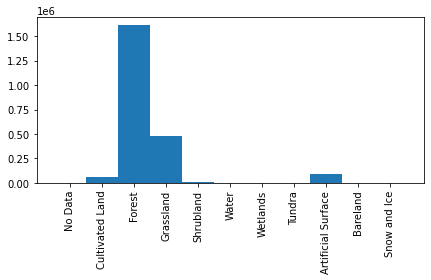

In [ ]:
summarize_result(prediction)

prediction_1d = prediction.reshape(prediction.shape[0] * prediction.shape[1])
single_hist(prediction_1d)

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


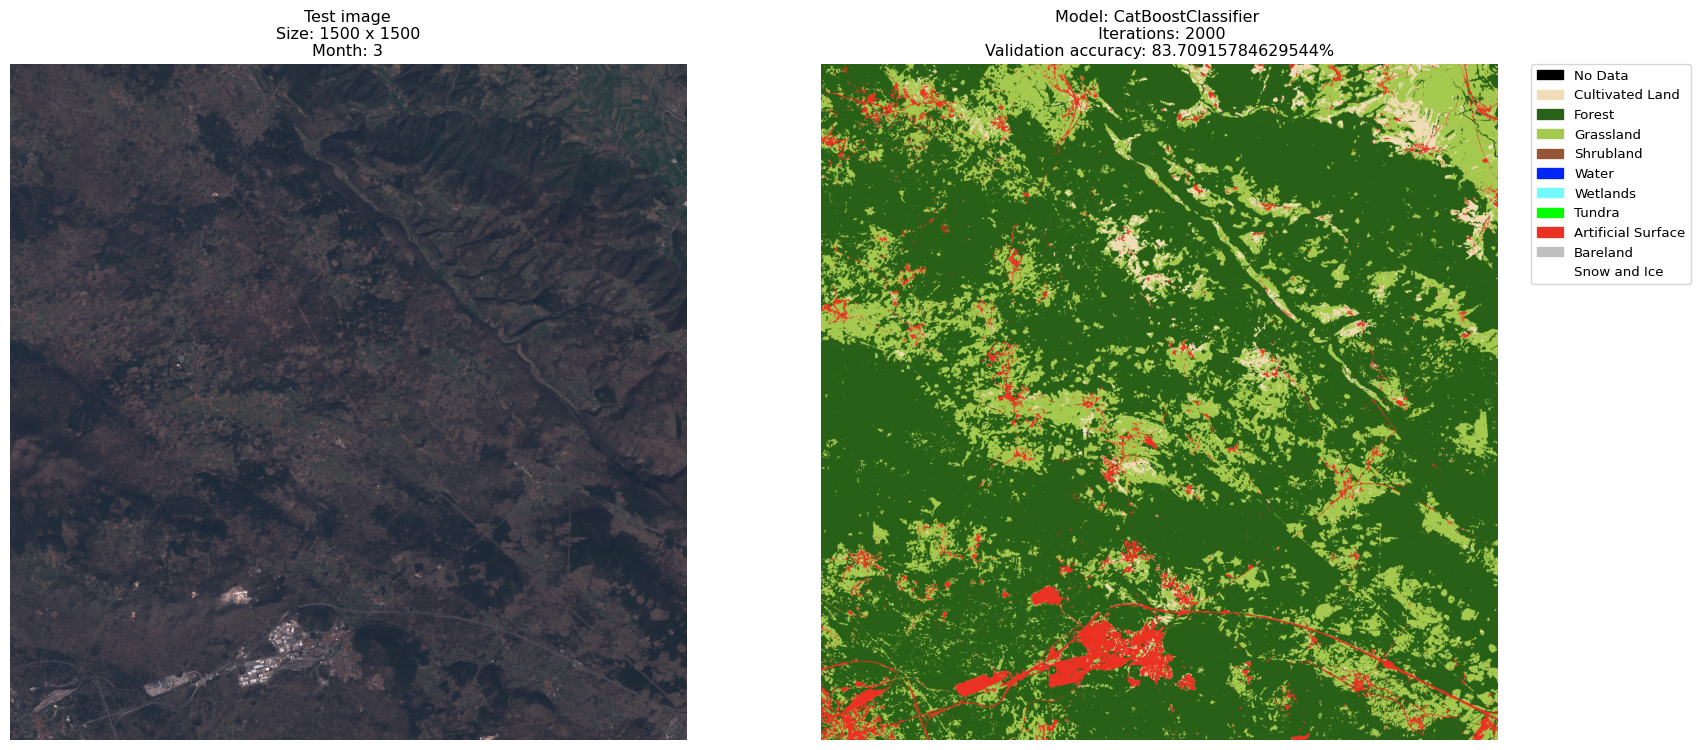

In [ ]:
plot_result(test, prediction)

## Export

In [ ]:
# save plot, model and predictions
#f.savefig(f'{PATH}plot.png')
np.save(f'{PATH}predictions.npy', prediction)
cbm_final.save_model(f'{PATH}final_model')